<a href="https://colab.research.google.com/github/revanth31-lab/loanrepay-prediction-ML-/blob/main/loanrepay_prediction_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV, KFold

# This connects to your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Read the file from your Drive
df = pd.read_csv("/content/drive/MyDrive/modified_data.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


credit.policy             purpose  int.rate  installment  log.annual.inc  \
0              1  debt_consolidation    0.1189       829.10       11.350407   
1              1         credit_card    0.1071       228.22       11.082143   
2              1  debt_consolidation    0.1357       366.86       10.373491   
3              1  debt_consolidation    0.1008       162.34       11.350407   
4              1         credit_card    0.1426       102.92       11.299732   

     dti  fico  days.with.cr.line  revol.bal  revol.util  inq.last.6mths  \
0  19.48   737        5639.958333      28854        52.1               0   
1  14.29   707        2760.000000      33623        76.7               0   
2  11.63   682        4710.000000       3511        25.6               1   
3   8.10   712        2699.958333      33667        73.2               1   
4  14.97   667        4066.000000       4740        39.5               0   

   delinq.2yrs  pub.rec  not.fully.paid  
0            0        0               0  
1            0        0               0  
2            0        0               0  
3            0        0               0  
4            1        0               0

In [6]:
# 1. Remove unnecessary columns
columns_to_exclude = ['credit.policy', 'purpose','not.fully.paid']
df2 = df.drop(columns_to_exclude, axis=1)

# 2. Handle Outliers in the 'dti' column
column = 'dti'

# Calculate Q1, Q3, and IQR
Q1 = df2[column].quantile(0.25)
Q3 = df2[column].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

# Replace values below the lower limit with the median
# Note: This code currently only fixes low outliers, not high ones.
df2[column] = np.where(
    df2[column] < lower_bound,
    df2[column].median(),
    df2[column]
)

# 3. Show statistical summary of the new dataframe
df2.describe()

int.rate  installment  log.annual.inc          dti         fico  \
count  9578.000000  9578.000000     9578.000000  9578.000000  9578.000000   
mean      0.122640   319.089413       10.932117    12.606679   710.846314   
std       0.026847   207.071301        0.614813     6.883970    37.970537   
min       0.060000    15.670000        7.547502     0.000000   612.000000   
25%       0.103900   163.770000       10.558414     7.212500   682.000000   
50%       0.122100   268.950000       10.928884    12.665000   707.000000   
75%       0.140700   432.762500       11.291293    17.950000   737.000000   
max       0.216400   940.140000       14.528354    29.960000   827.000000   

       days.with.cr.line     revol.bal   revol.util  inq.last.6mths  \
count        9578.000000  9.578000e+03  9578.000000     9578.000000   
mean         4560.767197  1.691396e+04    46.799236        1.577469   
std          2496.930377  3.375619e+04    29.014417        2.200245   
min           178.958333  0.000000e+00     0.000000        0.000000   
25%          2820.000000  3.187000e+03    22.600000        0.000000   
50%          4139.958333  8.596000e+03    46.300000        1.000000   
75%          5730.000000  1.824950e+04    70.900000        2.000000   
max         17639.958330  1.207359e+06   119.000000       33.000000   

       delinq.2yrs      pub.rec  
count  9578.000000  9578.000000  
mean      0.163708     0.062122  
std       0.546215     0.262126  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%       0.000000     0.000000  
max      13.000000     5.000000

In [7]:
import pandas as pd
from scipy.stats import skew, kurtosis

# Calculate skewness for all columns
skewness = df2.apply(skew)

# Calculate kurtosis for all columns
kurtosis_val = df2.apply(kurtosis) # Renamed variable to avoid conflict with function name

print("Skewness:")
print(skewness)
print("\nKurtosis:")
print(kurtosis_val)


Skewness:
int.rate              0.164394
installment           0.912380
log.annual.inc        0.028664
dti                   0.023937
fico                  0.471186
days.with.cr.line     1.155567
revol.bal            11.159310
revol.util            0.059976
inq.last.6mths        3.583590
delinq.2yrs           6.060844
pub.rec               5.125632
dtype: float64

Kurtosis:
int.rate              -0.224833
installment            0.137209
log.annual.inc         1.607538
dti                   -0.900512
fico                  -0.422718
days.with.cr.line      1.936223
revol.bal            259.519049
revol.util            -1.116511
inq.last.6mths        26.273784
delinq.2yrs           71.395271
pub.rec               38.760139
dtype: float64


In [8]:
# Calculate frequency of repayment status for each loan purpose
# We use 'df' here because it still contains the 'purpose' column
class_frequency = df.groupby('purpose')['not.fully.paid'].value_counts().unstack().fillna(0)

print("Class Frequency:")
print(class_frequency)

Class Frequency:
not.fully.paid         0    1
purpose                      
all_other           1944  387
credit_card         1116  146
debt_consolidation  3354  603
educational          274   69
home_improvement     522  107
major_purchase       388   49
small_business       447  172


In [9]:
# Analyze frequency of repayment status based on credit policy
# 1 = Met criteria, 0 = Did not meet criteria
class_frequency_policy = df.groupby('credit.policy')['not.fully.paid'].value_counts().unstack().fillna(0)

print("Class Frequency (Credit Policy vs Repayment):")
print(class_frequency_policy)

Class Frequency (Credit Policy vs Repayment):
not.fully.paid     0     1
credit.policy             
0               1349   519
1               6696  1014


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [11]:

#checking null values
df.isnull().sum()


credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

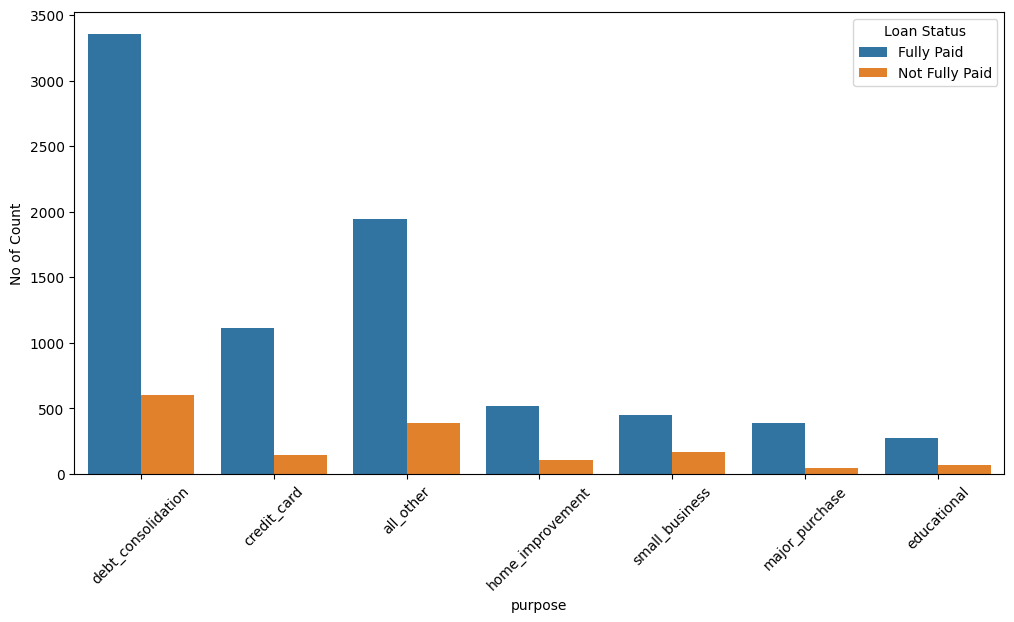

In [13]:
# 1. Import the files library (This was missing and caused the NameError)
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Set the size of the graph (Width=12 inches, Height=6 inches)
plt.figure(figsize=(12,6))

# 3. Create the Bar Chart (Countplot)
# data=df: Use the original dataframe because it has the 'purpose' column
# x='purpose': The different loan types go on the X-axis
# hue='not.fully.paid': Split each bar by whether they paid (0) or didn't pay (1)
ax = sns.countplot(data=df, x='purpose', hue='not.fully.paid')

# 4. Label the Y-axis
plt.ylabel('No of Count')

# 5. Rotate the X-axis text so the words don't overlap
plt.xticks(rotation=45)

# 6. Customize the Legend (The box that explains the colors)
# We get the current handles (colors) and labels from the graph
handles, labels = ax.get_legend_handles_labels()
# We replace the computer labels (0, 1) with human names ("Fully Paid", "Not Fully Paid")
ax.legend(handles, ["Fully Paid", "Not Fully Paid"], title='Loan Status', loc='upper right')

# 7. Save the image to the virtual machine's disk
plt.savefig('purpose.png')

# 8. Download the image to your laptop
files.download('purpose.png')

Generating pair plot... this may take a minute.


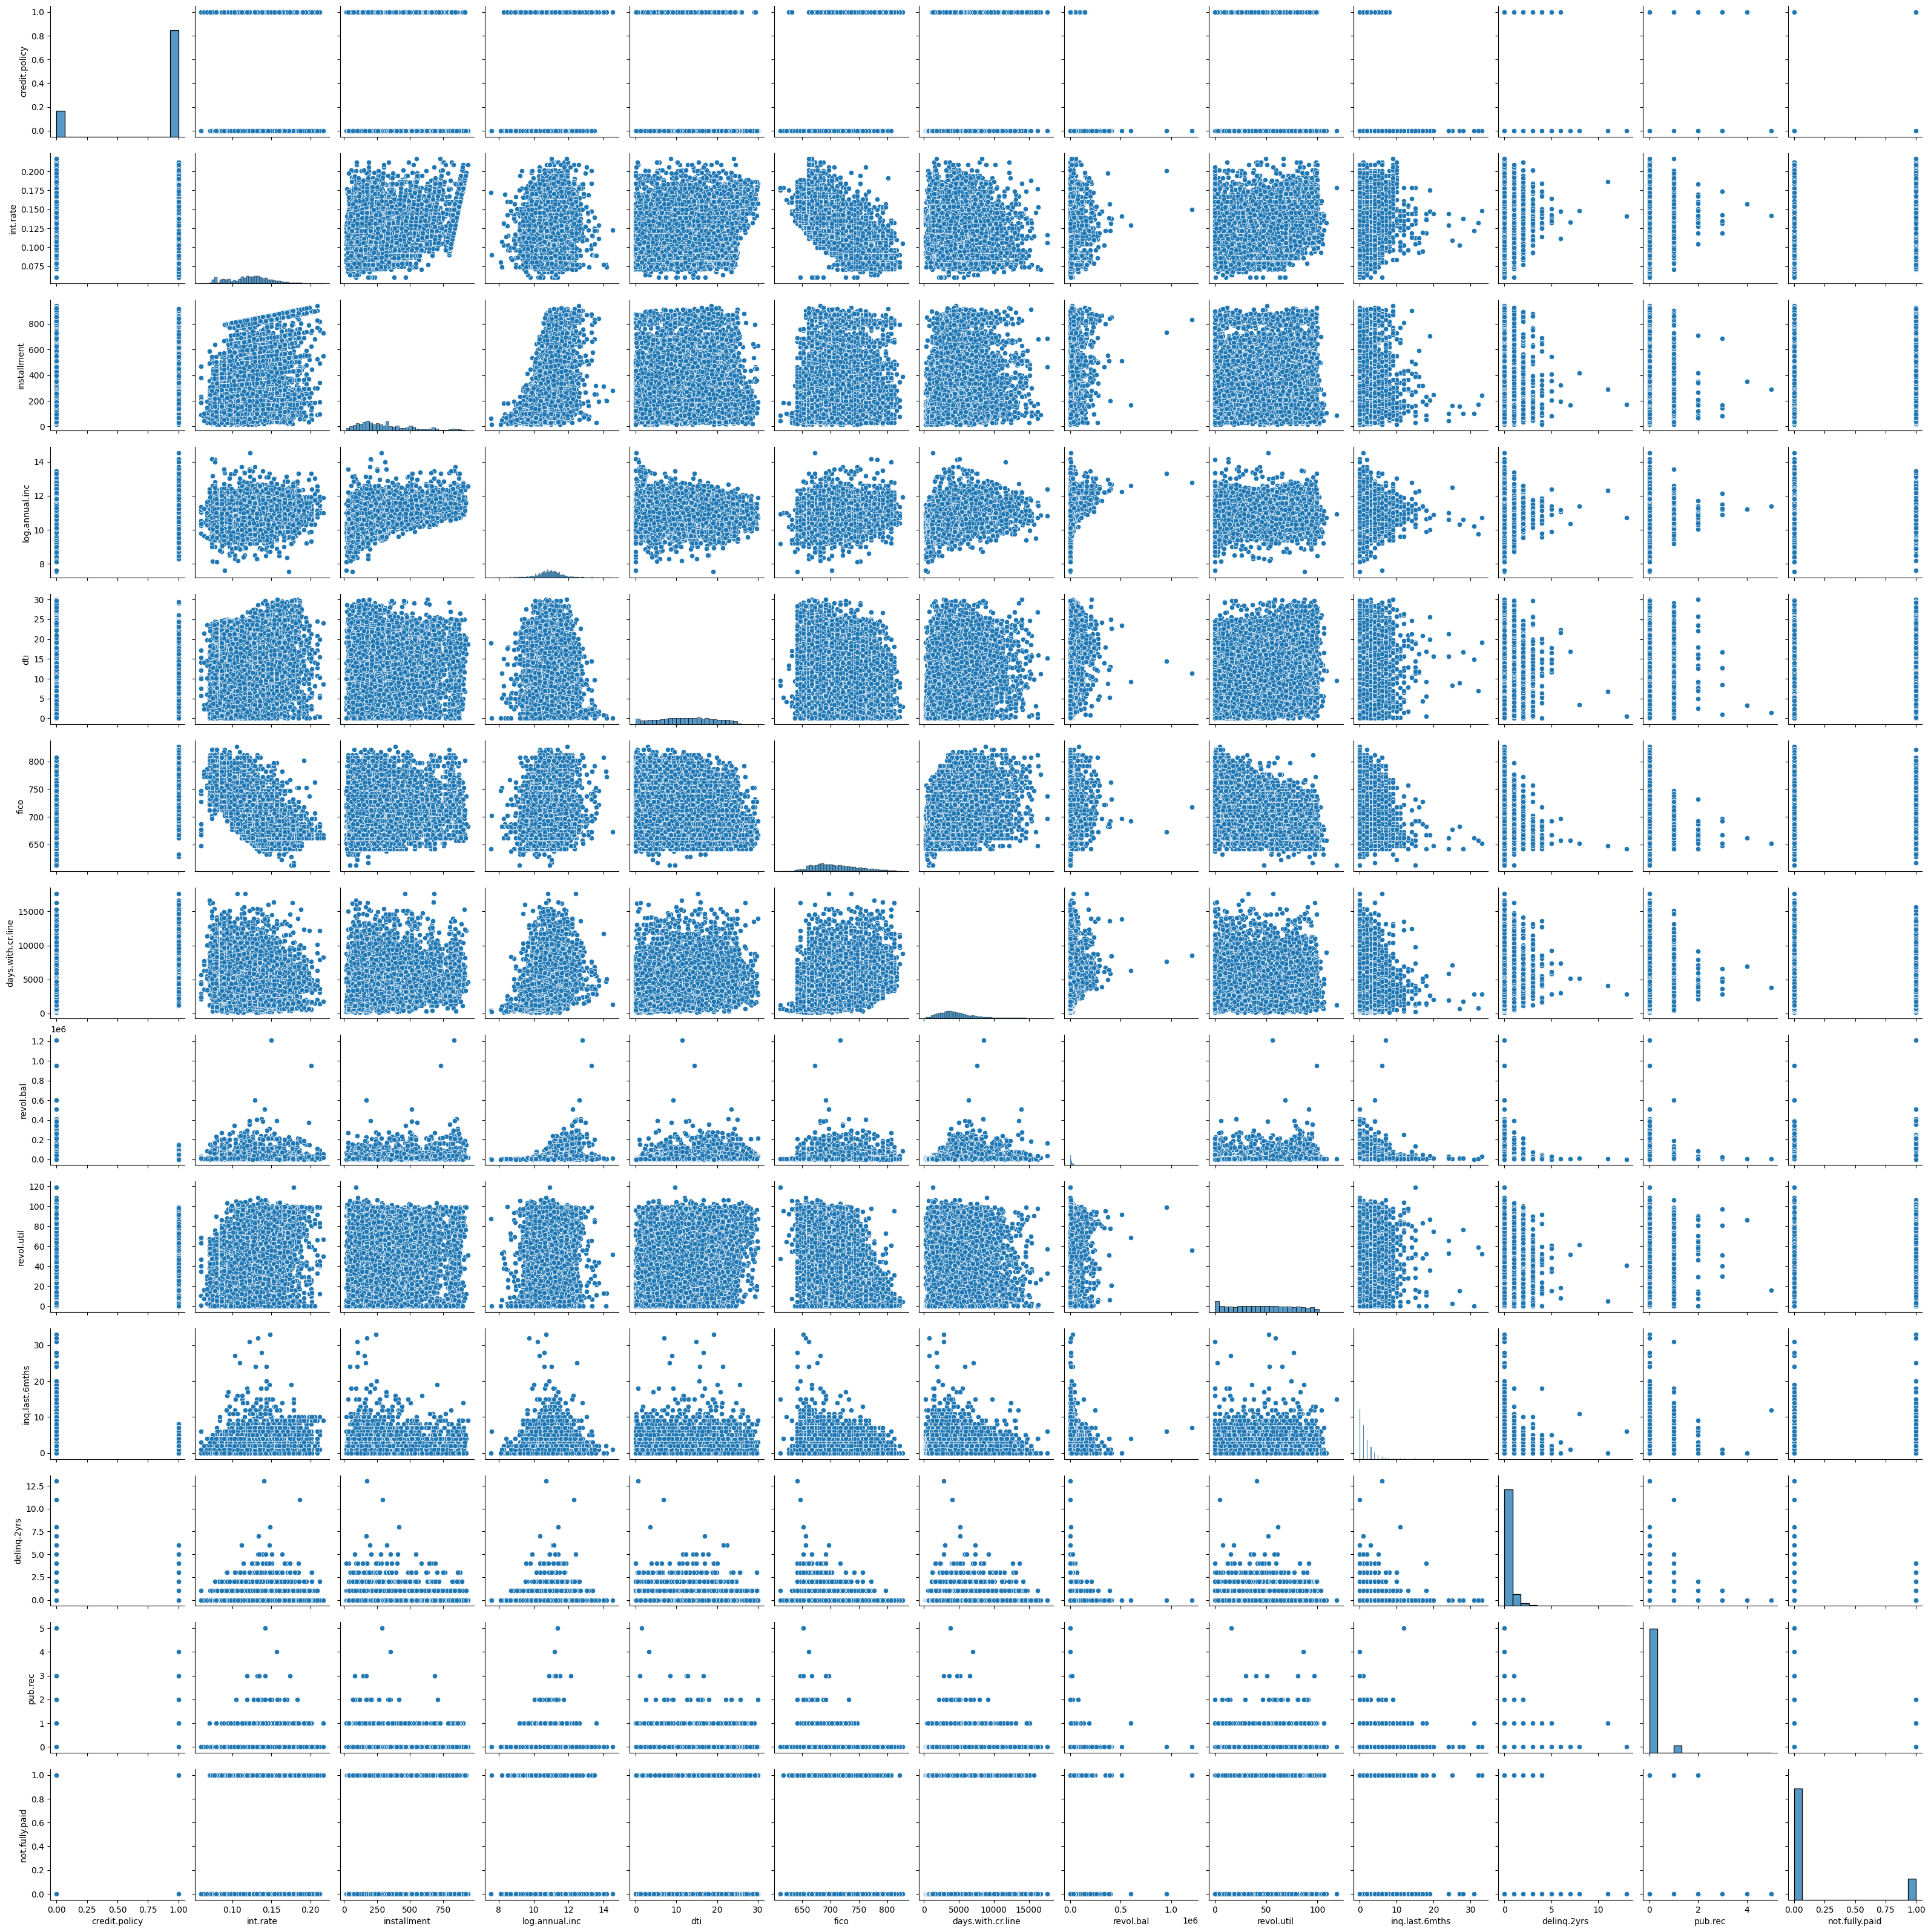

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Select only the numerical columns
# (The Pair Plot only works with numbers, not text like 'purpose')
numerical_columns = df.select_dtypes(include=['float64', 'int64'])

# 2. Create the Pair Plot
# This creates a grid of scatter plots for every combination of columns
print("Generating pair plot... this may take a minute.")
sns.pairplot(numerical_columns)

# 3. Display the plot
plt.show()

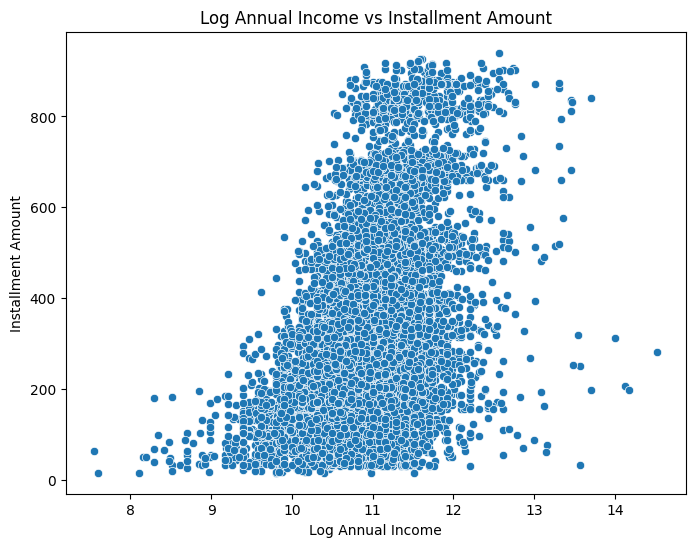

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot for log.annual.inc vs installment
plt.figure(figsize=(8, 6))
sns.scatterplot(x='log.annual.inc', y='installment', data=df)
plt.xlabel('Log Annual Income')
plt.ylabel('Installment Amount')
plt.title('Log Annual Income vs Installment Amount')
plt.show()


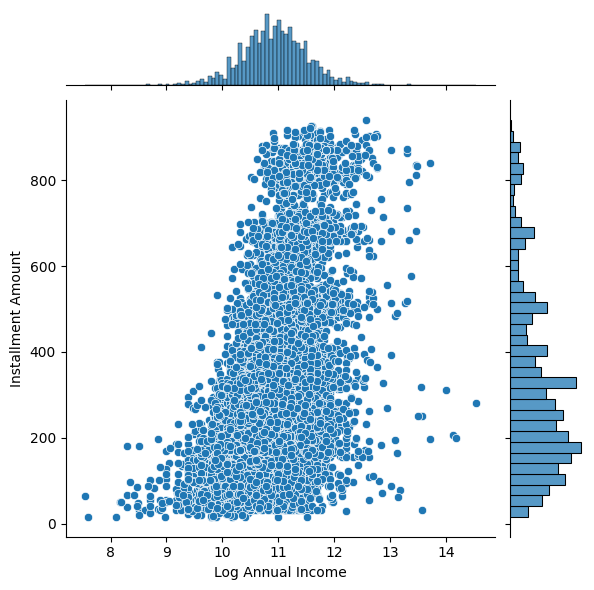

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Joint plot for log.annual.inc vs installment
sns.jointplot(x='log.annual.inc', y='installment', data=df, kind='scatter')
plt.xlabel('Log Annual Income')
plt.ylabel('Installment Amount')
plt.savefig('scatterplot_log_annual_inc_vs_installment.png')
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

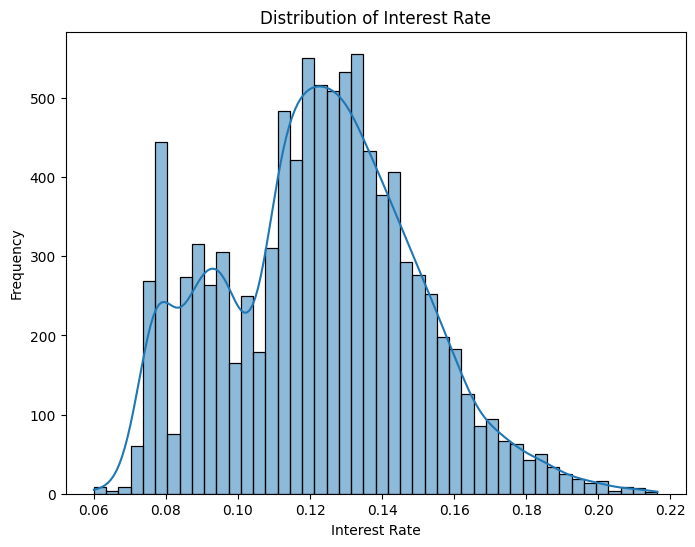

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

plt.figure(figsize=(8, 6))
sns.histplot(df['int.rate'], kde=True)
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.title('Distribution of Interest Rate')

# Save the plot as an image
plt.savefig('interest_rate_distribution.png')
files.download('interest_rate_distribution.png')

The observation that the frequency of interest rates starts low at 6%, increases up to 15% with a frequency of 500, and then decreases suggests some valuable insights for lenders:

Preferred Interest Rate Range: The increase in frequency from 6% to 15% indicates that there is a significant demand or preference among borrowers for interest rates within this range. Lenders can consider offering loan products at these rates to cater to the needs of borrowers who are more inclined towards this range. It suggests that there may be a larger pool of potential borrowers willing to accept loans at these rates.

Market Competition: The decrease in frequency beyond 15% implies that there might be fewer borrowers interested in higher interest rates. This could be an indication of market competition, where lenders offering loans at higher rates may face challenges in attracting borrowers. It suggests that lenders may need to reconsider their interest rate offerings or develop strategies to differentiate themselves in a competitive market.

Pricing Optimization: The observed trend in frequency can guide lenders in optimizing their pricing strategies. Lenders can use this information to strike a balance between offering competitive interest rates and maintaining profitability. By identifying the interest rate ranges that align with borrower preferences and have a higher frequency, lenders can strategically price their loans to attract borrowers while ensuring sustainable business operations.

Risk Assessment: The frequency distribution can provide insights into the risk associated with different interest rate ranges. The lower frequency at 6% suggests that borrowers may perceive this rate as more favorable and less risky. As the frequency increases towards 15%, lenders need to carefully assess the creditworthiness and repayment capacity of borrowers at these rates. The decreasing frequency beyond 15% may indicate potential challenges in repayment for loans at higher interest rates.

Overall, the insights from the frequency distribution of interest rates can help lenders make informed decisions regarding product offerings, pricing strategies, risk assessment, and competition analysis. By understanding borrower preferences and market dynamics, lenders can tailor their loan products to meet customer demands and enhance their competitive position in the lending market.


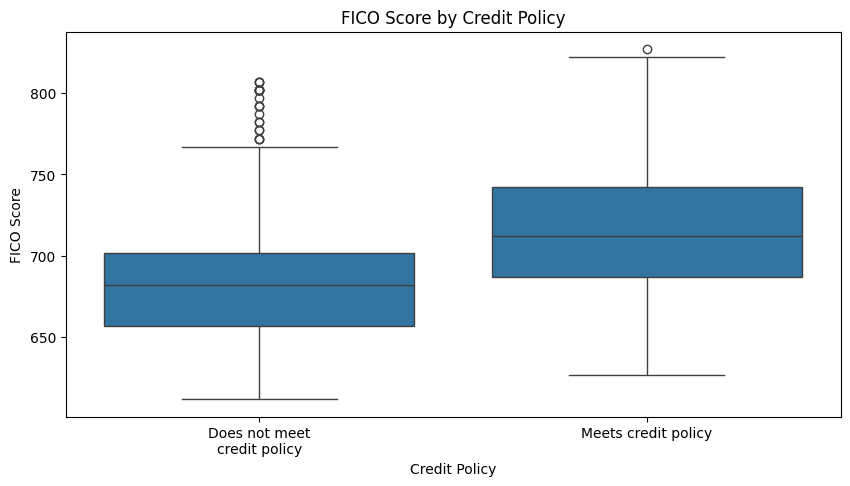

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='credit.policy', y='fico')
plt.title('FICO Score by Credit Policy')
plt.xlabel('Credit Policy')
plt.ylabel('FICO Score')
plt.xticks([0, 1], ['Does not meet\ncredit policy', 'Meets credit policy'])

# Save the plot as a PNG image
plt.savefig('FICO_Score_by_Credit_Policy.png')

# Show the plot
plt.show()

In [19]:
credit_policy_counts = df['credit.policy'].value_counts()
credit_policy_counts

credit.policy
1    7710
0    1868
Name: count, dtype: int64

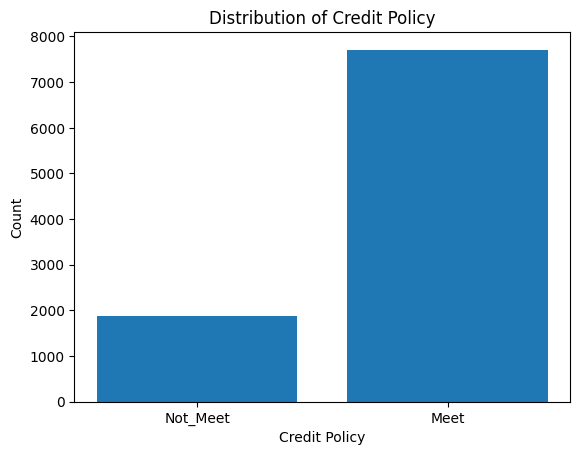

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [20]:
# Count the occurrences of each credit policy value
credit_policy_counts = df['credit.policy'].value_counts()

# Create the bar plot
plt.bar(credit_policy_counts.index, credit_policy_counts.values)

# Add labels and title
plt.xlabel('Credit Policy')
plt.ylabel('Count')
plt.title('Distribution of Credit Policy')

# Customize x-axis labels if needed
plt.xticks(credit_policy_counts.index, ['Meet', 'Not_Meet'])

# Display the plot
plt.show()

# Save and download the figure
plt.savefig('distribution_of_creditpolicy.png')
files.download('distribution_of_creditpolicy.png')

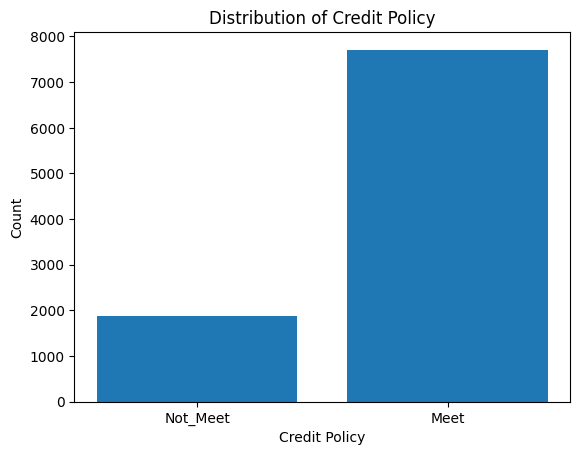

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt

# Count the occurrences of each credit policy value
credit_policy_counts = df['credit.policy'].value_counts()

# Create the bar plot
plt.bar(credit_policy_counts.index, credit_policy_counts.values)

# Add labels and title
plt.xlabel('Credit Policy')
plt.ylabel('Count')
plt.title('Distribution of Credit Policy')

# Customize x-axis labels if needed
plt.xticks(credit_policy_counts.index, ['Meet', 'Not_Meet'])

# Display the plot
plt.show()

# Save and download the figure
plt.savefig('distribution_of_creditpolicy.png')

# Download the saved figure in Google Colab
from google.colab import files
files.download('distribution_of_creditpolicy.png')


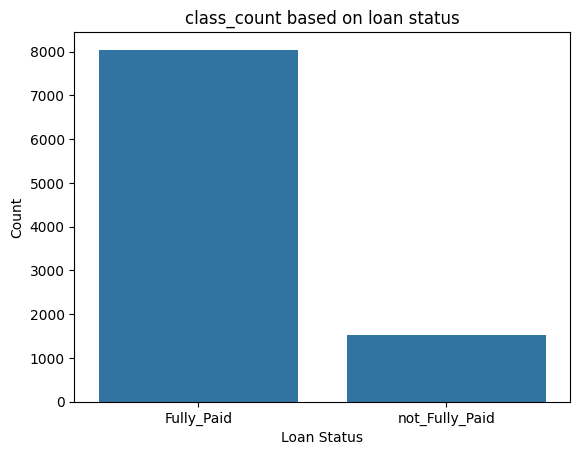

In [22]:

sns.countplot(data=df,x='not.fully.paid')
plt.title('class_count based on loan status')
# Set x-label and y-label
plt.xlabel('Loan Status')
plt.ylabel('Count')

# Setting custom x-axis labels
plt.xticks([0, 1], ['Fully_Paid', 'not_Fully_Paid'])

plt.savefig('df')  # Save the heatmap as an image file
plt.show()



In [23]:
# unique values in purpose attribute

df.purpose.value_counts()

purpose
debt_consolidation    3957
all_other             2331
credit_card           1262
home_improvement       629
small_business         619
major_purchase         437
educational            343
Name: count, dtype: int64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

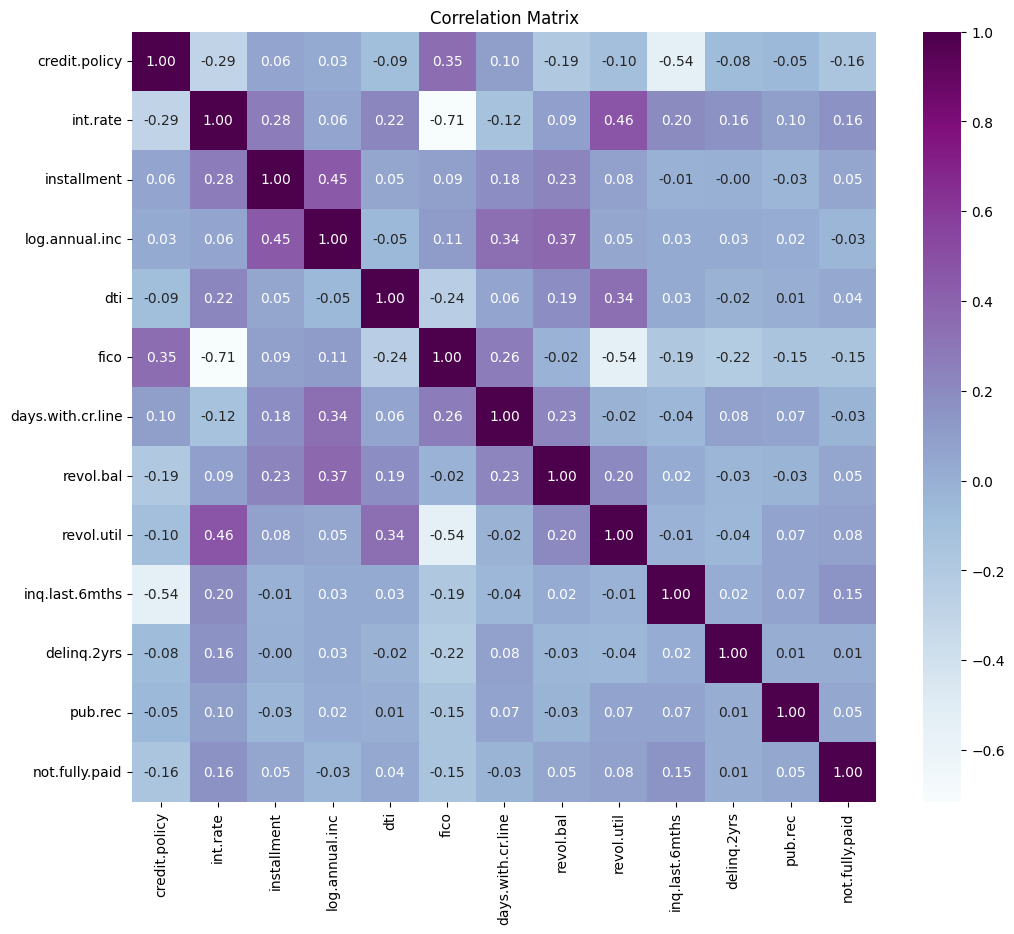

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# 1. Generate the correlation matrix
# numeric_only=True is required to ignore the text column 'purpose'
correlation_matrix = df.corr(numeric_only=True)

# 2. Plot the heatmap
plt.figure(figsize=(12, 10)) # Made it slightly larger to read easier
sns.heatmap(correlation_matrix, cmap='BuPu', annot=True, fmt=".2f")
plt.title("Correlation Matrix")

# 3. Save and Download
plt.savefig('heatmap.png')
files.download('heatmap.png')
plt.show()


credit_policy,int_rate,fico,inq.last.6mths has high impact on not_fully_paid

In [27]:
from sklearn.preprocessing import LabelEncoder

# 1. Initialize the encoder
encoder = LabelEncoder()

# 2. Transform the 'purpose' column
df['purpose'] = encoder.fit_transform(df['purpose'])

# 3. Check the result
# You will see the 'purpose' column is now numbers instead of words
df.head()

credit.policy  purpose  int.rate  installment  log.annual.inc    dti  fico  \
0              1        2    0.1189       829.10       11.350407  19.48   737   
1              1        1    0.1071       228.22       11.082143  14.29   707   
2              1        2    0.1357       366.86       10.373491  11.63   682   
3              1        2    0.1008       162.34       11.350407   8.10   712   
4              1        1    0.1426       102.92       11.299732  14.97   667   

   days.with.cr.line  revol.bal  revol.util  inq.last.6mths  delinq.2yrs  \
0        5639.958333      28854        52.1               0            0   
1        2760.000000      33623        76.7               0            0   
2        4710.000000       3511        25.6               1            0   
3        2699.958333      33667        73.2               1            0   
4        4066.000000       4740        39.5               0            1   

   pub.rec  not.fully.paid  
0        0               0  
1        0               0  
2        0               0  
3        0               0  
4        0               0

# LOGISTIC REGRESSION

In [28]:
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 1. Define Dependent (Target) and Independent (Features) variables
y = df['not.fully.paid']
X = df.drop('not.fully.paid', axis=1)

# 2. Add a constant (Intercept)
# Statsmodels requires this to calculate the baseline intercept
X = sm.add_constant(X)

# 3. Perform Logistic Regression
model = sm.Logit(y, X).fit()

# 4. Identify Significant Variables (P-value < 0.05)
# These are the factors that statistically affect the outcome
significant_vars = model.pvalues[model.pvalues < 0.05].index

# 5. Print Model Summary
print(model.summary())

# 6. Make Predictions (Threshold > 0.5)
y_pred = model.predict(X) > 0.5

# 7. Calculate Metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
cm = confusion_matrix(y, y_pred)

print("\nLogistic Regression Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("\nConfusion Matrix:")
print(cm)

print("\nSignificant Variables (Factors that actually matter):")
print(significant_vars)

Optimization terminated successfully.
         Current function value: 0.413820
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         not.fully.paid   No. Observations:                 9578
Model:                          Logit   Df Residuals:                     9564
Method:                           MLE   Df Model:                           13
Date:                Thu, 11 Dec 2025   Pseudo R-squ.:                 0.05899
Time:                        10:11:02   Log-Likelihood:                -3963.6
converged:                       True   LL-Null:                       -4212.0
Covariance Type:            nonrobust   LLR p-value:                 6.675e-98
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 6.9654      1.263      5.515      0.000       4.490       9.441
credit.p

In [29]:
# 1. Define the list of important columns (found in the previous step)
significant_vars = ['credit.policy', 'installment', 'log.annual.inc', 'fico', 'revol.bal', 'inq.last.6mths', 'pub.rec']

# 2. Create a new DataFrame with ONLY these columns
sig = df[significant_vars]

# 3. Check the new smaller table
sig.head()


credit.policy  installment  log.annual.inc  fico  revol.bal  \
0              1       829.10       11.350407   737      28854   
1              1       228.22       11.082143   707      33623   
2              1       366.86       10.373491   682       3511   
3              1       162.34       11.350407   712      33667   
4              1       102.92       11.299732   667       4740   

   inq.last.6mths  pub.rec  
0               0        0  
1               0        0  
2               1        0  
3               1        0  
4               0        0

# Balancing data with SMOTE method


In [30]:
import pandas as pd

# 1. Create X (Features)
# Drop the answer column so the model doesn't cheat
X1 = df.drop("not.fully.paid", axis=1)

# 2. Ensure all text is converted to numbers (One-Hot Encoding)
# Even though we used LabelEncoder earlier, this catches any remaining text columns
X1 = pd.get_dummies(X1)

# 3. Create Y (Target)
Y = df['not.fully.paid']

# 4. Verify the shapes
# X1 should have (rows, columns)
# Y should have (rows,)
print("Shape of X:", X1.shape)
print("Shape of Y:", Y.shape)

Shape of X: (9578, 13)
Shape of Y: (9578,)


In [31]:
from imblearn.over_sampling import SMOTE

# 1. Initialize the SMOTE tool
smote = SMOTE(random_state=42) # Added random_state for reproducibility

# 2. Resample the data
# This creates the new synthetic rows
x_smote, y_smote = smote.fit_resample(X1, Y)

# 3. Compare the sizes
print('Original dataset shape:', len(df))
print('Resampled dataset shape:', len(y_smote))

# Optional: Check the new balance
print("\nNew Class Distribution:")
print(y_smote.value_counts())

Original dataset shape: 9578
Resampled dataset shape: 16090

New Class Distribution:
not.fully.paid
0    8045
1    8045
Name: count, dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

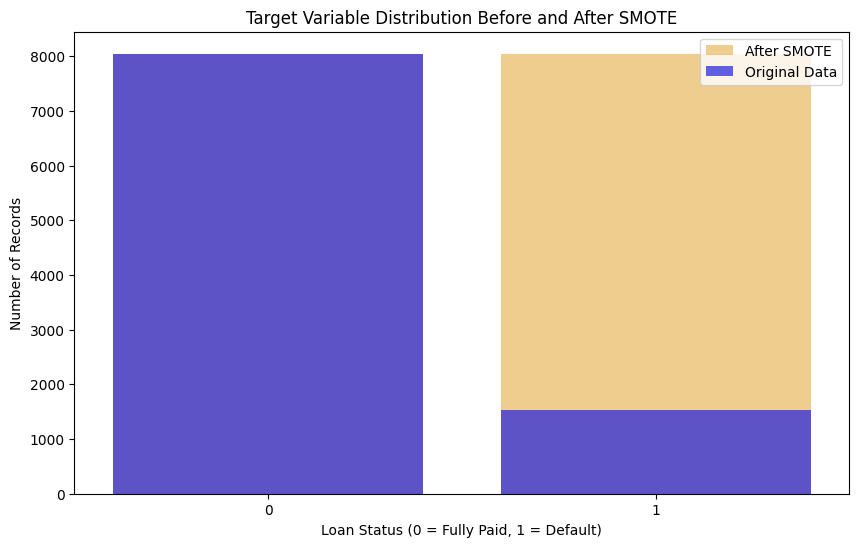

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# 1. Count occurrences
original_counts = df['not.fully.paid'].value_counts()
smote_counts = y_smote.value_counts()

# 2. Setup the plot
plt.figure(figsize=(10, 6))

# 3. Plot the 'After SMOTE' bars (The taller, lighter bars)
# We plot this first so it sits in the background
sns.barplot(x=smote_counts.index, y=smote_counts.values, color='orange', alpha=0.5, label='After SMOTE')

# 4. Plot the 'Original' bars (The shorter, darker bars)
# We plot this second so it sits in the foreground
sns.barplot(x=original_counts.index, y=original_counts.values, color='blue', alpha=0.7, label='Original Data')

# 5. Labels and Title
plt.title('Target Variable Distribution Before and After SMOTE')
plt.xlabel('Loan Status (0 = Fully Paid, 1 = Default)')
plt.ylabel('Number of Records')
plt.legend()

# 6. Save and Download
plt.savefig('target_variable_distribution.png')
files.download('target_variable_distribution.png')
plt.show()

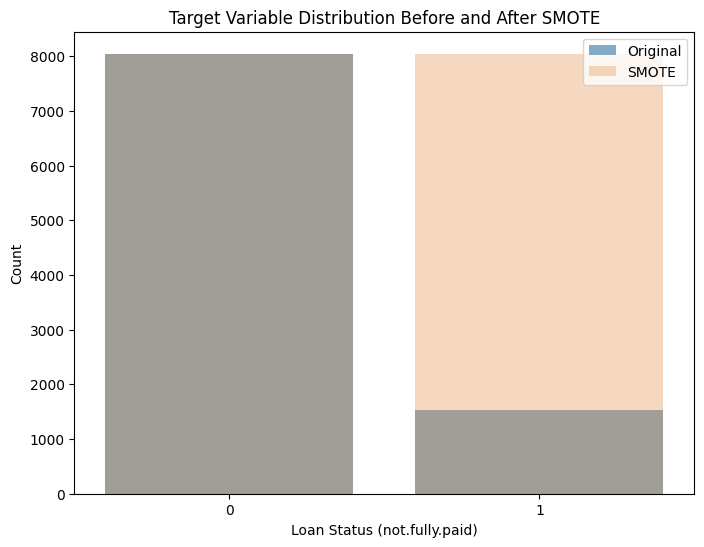

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define counts
original_counts = df['not.fully.paid'].value_counts()
smote_counts = y_smote.value_counts()

# 2. Define the palette (in case it wasn't defined earlier)
custom_palette = sns.color_palette(['#1f77b4', '#ff7f0e'])

# 3. Create the bar chart
plt.figure(figsize=(8, 6))

# Plot Original Data (Bottom layer)
sns.barplot(x=original_counts.index, y=original_counts.values, alpha=0.6, label='Original')

# Plot SMOTE Data (Top layer, semi-transparent)
# We force the color to orange (custom_palette[1]) to distinguish the synthetic data
sns.barplot(x=smote_counts.index, y=smote_counts.values, alpha=0.3, color=custom_palette[1], label='SMOTE')

# 4. Add labels
plt.title('Target Variable Distribution Before and After SMOTE')
plt.xlabel('Loan Status (not.fully.paid)')
plt.ylabel('Count')
plt.legend()

# 5. Display
plt.show()

# Test-train Split

In [34]:
from sklearn.model_selection import train_test_split

# 1. Split the data
# We use x_smote and y_smote because we want to train on the balanced data
X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.2, random_state=42)

# 2. Check the sizes to be sure
print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (12872, 13)
Testing Data Shape: (3218, 13)


# SVM

In [35]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 1. Create the Linear SVM classifier
# random_state=42 ensures you get the same result every time you run it
svm_model = LinearSVC(random_state=42, dual=False)

# 2. Train the model (Fit)
# This might take a few seconds as SVMs involve complex math
svm_model.fit(X_train, y_train)

# 3. Make predictions on the secret test data
svm_pred = svm_model.predict(X_test)

# 4. Calculate Scores
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_precision = precision_score(y_test, svm_pred)
svm_recall = recall_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred)
svm_cm = confusion_matrix(y_test, svm_pred)

# 5. Print Results
print("Linear SVM Metrics:")
print(f"Accuracy: {svm_accuracy:.4f}")
print(f"Precision: {svm_precision:.4f}")
print(f"Recall: {svm_recall:.4f}")
print(f"F1-score: {svm_f1:.4f}")
print("\nConfusion Matrix:")
print(svm_cm)

Linear SVM Metrics:
Accuracy: 0.6554
Precision: 0.7044
Recall: 0.5318
F1-score: 0.6060

Confusion Matrix:
[[1256  358]
 [ 751  853]]


# DECISION-TREE-CLASSIFIER

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 1. Initialize the Decision Tree
# max_depth=3 limits the tree to 3 levels of questions
dt_classifier = DecisionTreeClassifier(max_depth=3, random_state=42)

# 2. Train the model
dt_classifier.fit(X_train, y_train)

# 3. Make predictions
y_pred_dt = dt_classifier.predict(X_test)

# 4. Calculate Metrics
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_precision = precision_score(y_test, y_pred_dt)
dt_recall = recall_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)
dt_confusion_mat = confusion_matrix(y_test, y_pred_dt)

# 5. Print Results
print("Decision Tree Metrics:")
print(f"Accuracy: {dt_accuracy:.4f}")
print(f"Precision: {dt_precision:.4f}")
print(f"Recall: {dt_recall:.4f}")
print(f"F1-score: {dt_f1:.4f}")
print("\nConfusion Matrix:")
print(dt_confusion_mat)

Decision Tree Metrics:
Accuracy: 0.6641
Precision: 0.7502
Recall: 0.4888
F1-score: 0.5919

Confusion Matrix:
[[1353  261]
 [ 820  784]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

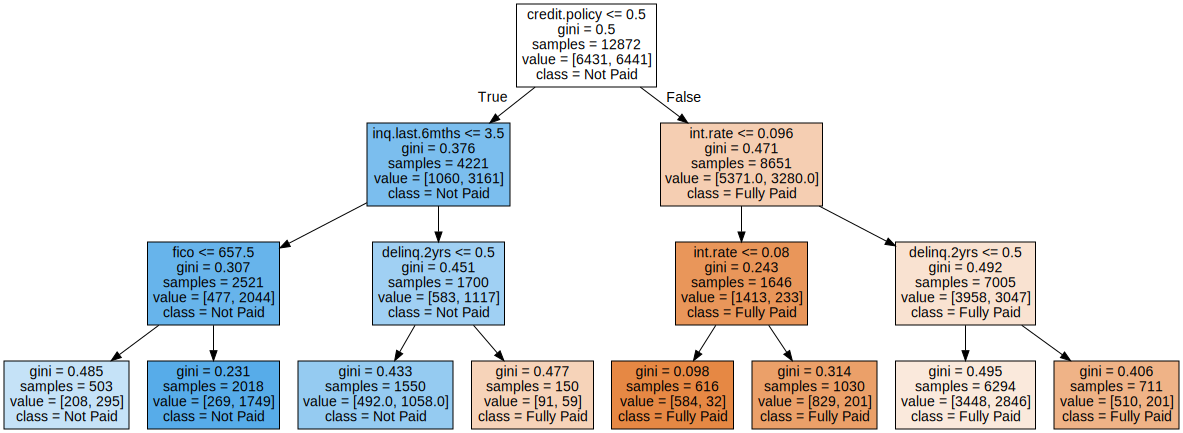

In [37]:
import matplotlib.pyplot as plt
from sklearn import tree
import graphviz
from google.colab import files

# 1. Generate the Graphviz data
# This converts the decision tree logic into a visual format
dot_data = tree.export_graphviz(dt_classifier,
                                out_file=None,
                                feature_names=X_train.columns,
                                class_names=['Fully Paid', 'Not Paid'],
                                filled=True)

# 2. Render the graph
graph = graphviz.Source(dot_data)

# 3. Save as a PDF file
graph.render("decision_tree_3")

# 4. Download the PDF to your computer
files.download("decision_tree_3.pdf")

# 5. Display the tree in the notebook
graph

# BAGGING

In [38]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 1. Initialize Bagging Classifier
# We use 10 Decision Trees working together
bagging_classifier = BaggingClassifier(estimator=DecisionTreeClassifier(),
                                       n_estimators=10,
                                       random_state=42)

# 2. Train the ensemble
bagging_classifier.fit(X_train, y_train)

# 3. Make predictions
bagging_pred = bagging_classifier.predict(X_test)

# 4. Calculate Metrics
bagging_accuracy = accuracy_score(y_test, bagging_pred)
bagging_precision = precision_score(y_test, bagging_pred)
bagging_recall = recall_score(y_test, bagging_pred)
bagging_f1 = f1_score(y_test, bagging_pred)
bagging_cm = confusion_matrix(y_test, bagging_pred)

# 5. Print Results
print("Bagging Metrics:")
print(f"Accuracy: {bagging_accuracy:.4f}")
print(f"Precision: {bagging_precision:.4f}")
print(f"Recall: {bagging_recall:.4f}")
print(f"F1-score: {bagging_f1:.4f}")
print("\nConfusion Matrix:")
print(bagging_cm)

Bagging Metrics:
Accuracy: 0.8282
Precision: 0.8441
Recall: 0.8036
F1-score: 0.8234

Confusion Matrix:
[[1376  238]
 [ 315 1289]]


# AdaBoosting

In [39]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 1. Initialize AdaBoost
# We use Decision Tree "Stumps" (depth=1) as the building blocks
adaboost_classifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                         n_estimators=200,
                                         random_state=42)

# 2. Train the model
adaboost_classifier.fit(X_train, y_train)

# 3. Make predictions
adaboost_pred = adaboost_classifier.predict(X_test)

# 4. Calculate Metrics
adaboost_accuracy = accuracy_score(y_test, adaboost_pred)
adaboost_precision = precision_score(y_test, adaboost_pred)
adaboost_recall = recall_score(y_test, adaboost_pred)
adaboost_f1 = f1_score(y_test, adaboost_pred)
adaboost_cm = confusion_matrix(y_test, adaboost_pred)

# 5. Print Results
print("AdaBoost Metrics:")
print(f"Accuracy: {adaboost_accuracy:.4f}")
print(f"Precision: {adaboost_precision:.4f}")
print(f"Recall: {adaboost_recall:.4f}")
print(f"F1-score: {adaboost_f1:.4f}")
print("\nConfusion Matrix:")
print(adaboost_cm)

AdaBoost Metrics:
Accuracy: 0.7020
Precision: 0.7045
Recall: 0.6926
F1-score: 0.6985

Confusion Matrix:
[[1148  466]
 [ 493 1111]]


# Random-Forest-Classifier

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 1. Initialize Random Forest
# n_estimators=100: We are building 100 trees
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Train the model
rf_classifier.fit(X_train, y_train)

# 3. Make predictions
rf_pred = rf_classifier.predict(X_test)

# 4. Calculate Metrics
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_cm = confusion_matrix(y_test, rf_pred)

# 5. Print Results
print("Random Forest Metrics:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1-score: {rf_f1:.4f}")
print("\nConfusion Matrix:")
print(rf_cm)

Random Forest Metrics:
Accuracy: 0.8595
Precision: 0.8591
Recall: 0.8591
F1-score: 0.8591

Confusion Matrix:
[[1388  226]
 [ 226 1378]]


# LOGISTIC REGRESSION

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 1. Create the Logistic Regression classifier
# random_state=5 ensures consistency
logreg_classifier = LogisticRegression(random_state=5, max_iter=1000) # Increased max_iter to prevent convergence warnings

# 2. Train on the SMOTE-balanced training data
logreg_classifier.fit(X_train, y_train)

# 3. Make predictions on the test data
logreg_pred = logreg_classifier.predict(X_test)

# 4. Calculate Metrics
logreg_accuracy = accuracy_score(y_test, logreg_pred)
logreg_precision = precision_score(y_test, logreg_pred)
logreg_recall = recall_score(y_test, logreg_pred)
logreg_f1 = f1_score(y_test, logreg_pred)
logreg_cm = confusion_matrix(y_test, logreg_pred)

# 5. Calculate probabilities (useful for ROC curves later)
logreg_probabilities = logreg_classifier.predict_proba(X_test)
log_odds = logreg_probabilities[:, 1]

# 6. Print Results
print("Logistic Regression (Balanced) Metrics:")
print(f"Accuracy: {logreg_accuracy:.4f}")
print(f"Precision: {logreg_precision:.4f}")
print(f"Recall: {logreg_recall:.4f}")
print(f"F1-score: {logreg_f1:.4f}")
print("\nConfusion Matrix:")
print(logreg_cm)

Logistic Regression (Balanced) Metrics:
Accuracy: 0.6557
Precision: 0.7098
Recall: 0.5231
F1-score: 0.6023

Confusion Matrix:
[[1271  343]
 [ 765  839]]


# KNN-Classifier

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

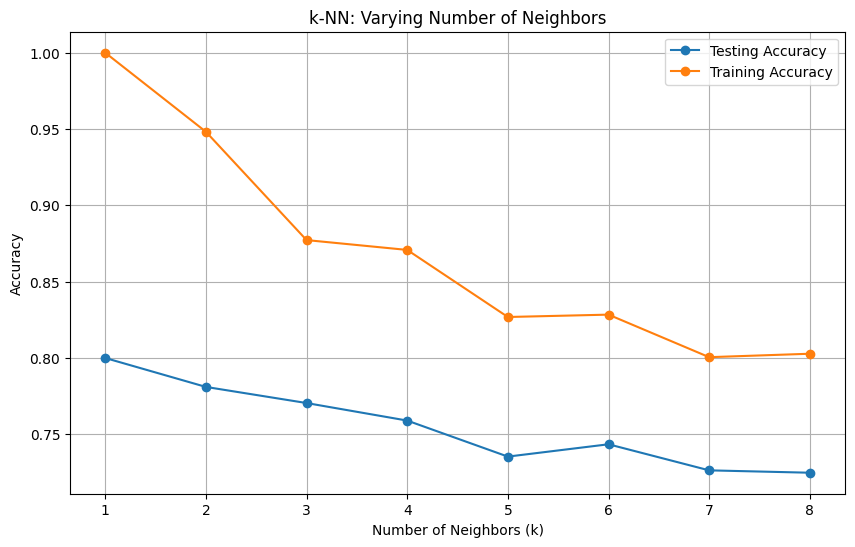

In [42]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# 1. Setup arrays to store results
neighbors = np.arange(1, 9) # We will test k=1 to k=8
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# 2. Loop through different values of k
for i, k in enumerate(neighbors):
    # Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the model
    knn.fit(X_train, y_train)

    # Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    # Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test)

# 3. Generate plot
plt.figure(figsize=(10, 6))
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy', marker='o')
plt.plot(neighbors, train_accuracy, label='Training Accuracy', marker='o')
plt.legend()
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.grid(True)

# 4. Save and Download
plt.savefig('knn_tuning.png')
files.download('knn_tuning.png')
plt.show()

In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 1. Setup a knn classifier with k=1 neighbor
knn = KNeighborsClassifier(n_neighbors=1)

# 2. Fit the model
knn.fit(X_train, y_train)

# 3. Make predictions
KNN_pred = knn.predict(X_test)

# 4. Compute evaluation metrics for KNN
KNN_accuracy = accuracy_score(y_test, KNN_pred)
KNN_precision = precision_score(y_test, KNN_pred)
KNN_recall = recall_score(y_test, KNN_pred)
KNN_f1 = f1_score(y_test, KNN_pred)
KNN_cm = confusion_matrix(y_test, KNN_pred)

# 5. Print Results
print("KNN Metrics (k=1):")
print(f"Accuracy: {KNN_accuracy:.4f}")
print(f"Precision: {KNN_precision:.4f}")
print(f"Recall: {KNN_recall:.4f}")
print(f"F1-score: {KNN_f1:.4f}")
print("\nConfusion Matrix:")
print(KNN_cm)

KNN Metrics (k=1):
Accuracy: 0.7999
Precision: 0.7542
Recall: 0.8878
F1-score: 0.8156

Confusion Matrix:
[[1150  464]
 [ 180 1424]]


# ANN

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy

# 1. Scale the features (Crucial for Neural Networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Build the ANN model
model = Sequential()
# Hidden Layer: 64 neurons
model.add(Dense(units=64, activation='relu', input_dim=X_train_scaled.shape[1]))
# Output Layer: 1 neuron (0 to 1 probability)
model.add(Dense(units=1, activation='sigmoid'))

# 3. Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[BinaryAccuracy()])

# 4. Train the model
# epochs=10 means it will study the dataset 10 times
print("Starting training...")
model.fit(X_train_scaled, y_train, batch_size=64, epochs=10, verbose=1)

# 5. Make Predictions
ann_prob = model.predict(X_test_scaled).ravel()

# 6. Calculate ROC/AUC metrics
ann_fpr, ann_tpr, _ = roc_curve(y_test, ann_prob)
ann_auc = auc(ann_fpr, ann_tpr)

print(f"\nANN AUC Score: {ann_auc:.4f}")

Starting training...
Epoch 1/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.5868 - loss: 0.6642
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.6782 - loss: 0.5906
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.6909 - loss: 0.5750
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.6963 - loss: 0.5664
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.7026 - loss: 0.5606
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.6967 - loss: 0.5673
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.7028 - loss: 0.5647
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.7064 - loss: 0.5536
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.7096 - loss: 0.5513
Epoch 10/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.7080 - loss: 0.5554
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

ANN AU

# Gaussian Naive Bayes Classifier

In [45]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# 1. Scale the features
# Naive Bayes works better when features are on the same scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Create and Train the Classifier
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(X_train_scaled, y_train)

# 3. Make predictions
nb_pred = naive_bayes_classifier.predict(X_test_scaled)

# 4. Calculate Metrics
nb_accuracy = accuracy_score(y_test, nb_pred)
nb_precision = precision_score(y_test, nb_pred)
nb_recall = recall_score(y_test, nb_pred)
nb_f1 = f1_score(y_test, nb_pred)
nb_cm = confusion_matrix(y_test, nb_pred)

# 5. Print Metrics
print("Naive Bayes Metrics:")
print(f"Accuracy: {nb_accuracy:.4f}")
print(f"Precision: {nb_precision:.4f}")
print(f"Recall: {nb_recall:.4f}")
print(f"F1-score: {nb_f1:.4f}")
print("\nConfusion Matrix:")
print(nb_cm)

# 6. Calculate Probabilities & AUC (for the final graph)
nb_prob = naive_bayes_classifier.predict_proba(X_test_scaled)[:, 1]
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_prob)
nb_auc = auc(nb_fpr, nb_tpr)
print(f"\nNaive Bayes AUC Score: {nb_auc:.4f}")

Naive Bayes Metrics:
Accuracy: 0.6610
Precision: 0.6380
Recall: 0.7394
F1-score: 0.6850

Confusion Matrix:
[[ 941  673]
 [ 418 1186]]

Naive Bayes AUC Score: 0.7204


# ROC Curves

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

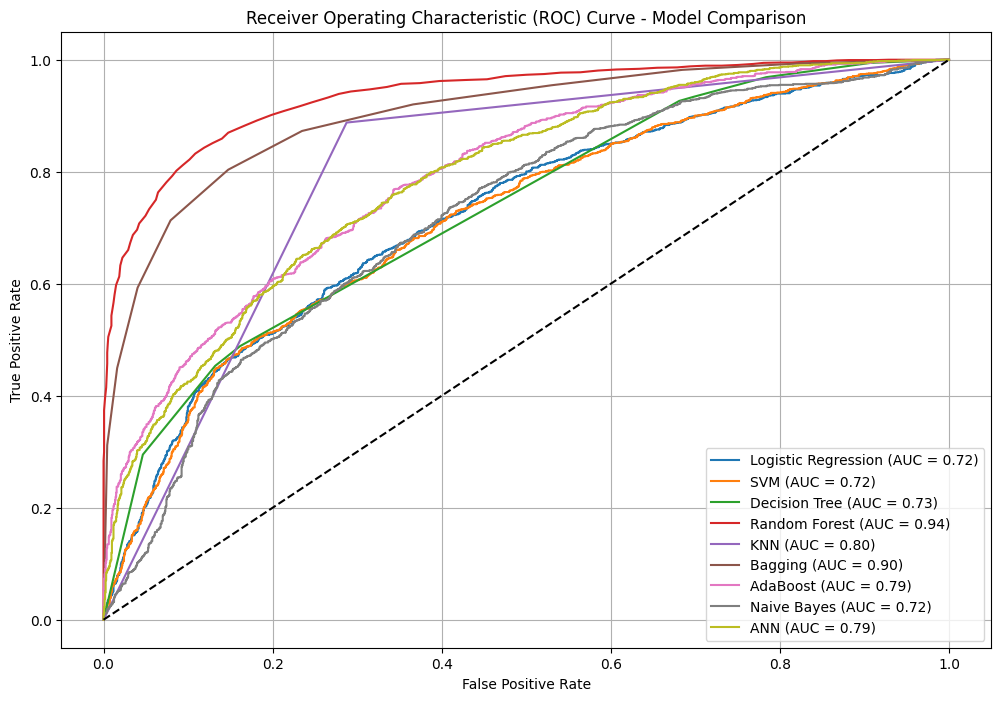

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from google.colab import files

# 1. Compute predicted probabilities for the models that support it
# Note: specific scaling might be needed for ANN/NB if not done in previous steps,
# but here we use the variables available in memory.

logreg_prob = logreg_classifier.predict_proba(X_test)[:, 1]
svm_scores = svm_model.decision_function(X_test)
dt_scores = dt_classifier.predict_proba(X_test)[:, 1]
rf_prob = rf_classifier.predict_proba(X_test)[:, 1]
knn_prob = knn.predict_proba(X_test)[:, 1]
bagging_prob = bagging_classifier.predict_proba(X_test)[:, 1]
adaboost_prob = adaboost_classifier.predict_proba(X_test)[:, 1]

# 2. Compute FPR and TPR for each classifier
logreg_fpr, logreg_tpr, _ = roc_curve(y_test, logreg_prob)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_scores)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_scores)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_prob)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_prob)
bagging_fpr, bagging_tpr, _ = roc_curve(y_test, bagging_prob)
adaboost_fpr, adaboost_tpr, _ = roc_curve(y_test, adaboost_prob)

# 3. Compute AUC for each classifier
logreg_auc = auc(logreg_fpr, logreg_tpr)
svm_auc = auc(svm_fpr, svm_tpr)
dt_auc = auc(dt_fpr, dt_tpr)
rf_auc = auc(rf_fpr, rf_tpr)
knn_auc = auc(knn_fpr, knn_tpr)
bagging_auc = auc(bagging_fpr, bagging_tpr)
adaboost_auc = auc(adaboost_fpr, adaboost_tpr)

# 4. Plot the ROC Curves
plt.figure(figsize=(12, 8)) # Make the plot larger

plt.plot(logreg_fpr, logreg_tpr, label='Logistic Regression (AUC = {:.2f})'.format(logreg_auc))
plt.plot(svm_fpr, svm_tpr, label='SVM (AUC = {:.2f})'.format(svm_auc))
plt.plot(dt_fpr, dt_tpr, label='Decision Tree (AUC = {:.2f})'.format(dt_auc))
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC = {:.2f})'.format(rf_auc))
plt.plot(knn_fpr, knn_tpr, label='KNN (AUC = {:.2f})'.format(knn_auc))
plt.plot(bagging_fpr, bagging_tpr, label='Bagging (AUC = {:.2f})'.format(bagging_auc))
plt.plot(adaboost_fpr, adaboost_tpr, label='AdaBoost (AUC = {:.2f})'.format(adaboost_auc))

# Ensure nb_fpr and ann_fpr exist from previous steps
if 'nb_fpr' in locals():
    plt.plot(nb_fpr, nb_tpr, label='Naive Bayes (AUC = {:.2f})'.format(nb_auc))
if 'ann_fpr' in locals():
    plt.plot(ann_fpr, ann_tpr, label='ANN (AUC = {:.2f})'.format(ann_auc))

# 5. Final Graph Settings
plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal line (Random Guessing)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Model Comparison')
plt.legend(loc='lower right')
plt.grid(True)

# 6. Save and Download
plt.savefig('final_roc_comparison.png')
files.download('final_roc_comparison.png')
plt.show()